In [266]:
from concurrent.futures import ThreadPoolExecutor
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.stem import SnowballStemmer
import nltk
nltk.download('punkt')

stemmer = SnowballStemmer("english")
#define dictionary
openness_to_change = [
    "freedom", "liberty", "innovation", "change", "progress",
    "reform", "future", "creativity", "dream", "aspiration",
    "hope", "new", "opportunity", "vision", "imagination",
    "bold", "renewal", "transformation", "explore", "possibility",
    "potential", "advancement", "modern", "shift", "trailblaze",
    "lead", "breakthrough", "expand", "dynamic", "revitalize",
    "fresh", "unleash", "rethink", "reimagine", "emerge",
    "reinvent", "courage", "pioneer", "initiative", "path",
    "discover", "awakening", "creative", "unfold", "novel",
    "inspire", "movement", "exploration", "adapt", "open", 
    'adventure','exciting','fun', 'pleasure'  #word from 21 item question 
]


self_enhancement = [
    "power", "success", "strength", "leadership", "greatness",
    "achievement", "ambition", "victory", "win", "glory",
    "dominance", "control", "command", "triumph", "competitive",
    "drive", "excel", "pursuit", "goal", "influence",
    "mastery", "authority", "prestige", "excellence", "merit",
    "fame", "recognition", "courage", "boldness", "resolve",
    "fearless", "determination", "capacity", "build",
    "forge", "conquer", "expand", "secure", "rise",
    "strong", "heroic", "forward", "lead", 
    "milestone", "achievement", "command", "focus", "target",
    "fun" , "pleasure", "admire", "ability","rich",'money','wealth' #word from 21 item question
]

conservation = [
    "tradition", "heritage", "faith", "family", "God",
    "order", "duty", "responsibility", "security", "protect",
    "defend", "preserve", "stability", "unity", "honor",
    "law", "custom", "discipline", "foundation", "obedience",
    "country", "homeland", "loyalty", "legacy", "sacrifice",
    "endure", "patriotism", "culture", "restore", "guard",
    "principle", "obedience", "respect", "safety",
    "defense", "maintain", "faithful", "uphold", "sacred",
    "integrity", "traditions", "belong", "structure", "moral",
    "stable", "preservation", "commitment", "commandment", "reverence",
    "safe","ensure","rule","tradition","humble", "modest" #word from 21 item question
]

self_transcendence = [
    "justice", "equality", "compassion", "peace", "kindness",
    "care", "dignity", "unity", "inclusion", "solidarity",
    "humanity", "service", "respect", "rights", "freedom",
    "tolerance", "empathy", "support", "cooperation", "altruism",
    "help", "uplift", "share", "heal", "welfare",
    "together", "bridge", "hope", "forgive", "aid",
    "nurture", "generosity", "civility", "brotherhood", "neighbor",
    "liberty", "reconciliation", "open", "grace", "community",
    "embrace", "benevolence", "equal", "mutual",
    "serve", "affirm", "humility", "moral", "voice",
    "wellbeing", "nature", "environment"  #word from 21 item question
]
#stem dictionary
stemmed_openness = [stemmer.stem(word) for word in openness_to_change]
stemmed_self_enhancement = [stemmer.stem(word) for word in self_enhancement]
stemmed_conservation = [stemmer.stem(word) for word in conservation]
stemmed_self_transcendence = [stemmer.stem(word) for word in self_transcendence]

#function rate text using qwen
def rate_paragraph_ideology_qwen(paragraph, model="qwen2.5", base_url="http://localhost:11434"):
    prompt = f"""You are an expert in political psychology. Classify the dominant human value expressed in this paragraph according to Schwartz's theory:
\"\"\"{paragraph}\"\"\"

Respond with:
- 'openness' for Openness to Change,
- 'self-enhancement' for Self-Enhancement,
- 'conservation' for Conservation,
- 'self-transcendence' for Self-Transcendence,
- or 'neutral' if none apply. 
Return one word only, paragraph's human value:
"""

    
    api_generate = f"{base_url}/api/generate"
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False,
        "options": {
            "temperature": 0.0  # Recommended for classification
        }
    }

    try:
        response = requests.post(api_generate, json=payload)
        response.raise_for_status()
        data = response.json()

        # Clean and parse the output
        output = data.get("response", "").strip()
        if output.lower() in ["openness", "self-enhancement", "conservation" , "self-transcendence" , "neutral" ]:
            return output.lower()
        else:
            print(f"[WARN] Unexpected response content: {output}")
            return 'Unknown'  
    except Exception as e:
        print(f"[ERROR] LLM error for model {model}: {e}")
        return 0



#function rate text using other model
def rate_paragraph_ideology(paragraph,model):
    prompt = f"""You are an expert in political psychology. Classify the dominant human value expressed in this paragraph according to Schwartz's theory:
\"\"\"{paragraph}\"\"\"

Respond with:
- 'openness' for Openness to Change,
- 'self-enhancement' for Self-Enhancement,
- 'conservation' for Conservation,
- 'self-transcendence' for Self-Transcendence,
- or 'neutral' if none apply.
Return one word only, paragraph's human value:
"""

    
    try:
        res = requests.post(
            "http://localhost:11434/api/generate",
            json={
                "model": model,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "temperature": 0
                }
            }
        )
        score_str = res.json()["response"].strip()
        return score_str.lower() if score_str.lower() in  ["openness", "self-enhancement", "conservation" , "self-transcendence" , "neutral" ] else 'unknown'
    except Exception as e:
        print(f"LLM error: {e}")
        return 0


# Base URL pattern to scrap text
BASE_URL = 'https://www.presidency.ucsb.edu/documents/inaugural-address-{}'
special_cases = {
    55: "https://www.presidency.ucsb.edu/documents/second-inaugural-address",
    56: "https://www.presidency.ucsb.edu/documents/the-presidents-inaugural-address",
    57: "https://www.presidency.ucsb.edu/documents/third-inaugural-address",
    58: "https://www.presidency.ucsb.edu/documents/oath-office-and-second-inaugural-address",
    59: 'https://www.presidency.ucsb.edu/documents/inaugural-address'
}


# Function to stem text
def stem_text(text):
    words = text.lower().split()
    return [stemmer.stem(word) for word in words]

# List to hold paragraph-level data
speech_data = []

# Loop through the document IDs and fetch their data
for doc_id in range(0, 60):  # Extend range as needed
    url = special_cases.get(doc_id, BASE_URL.format(doc_id))  # fallback to BASE_URL if not special
    try:
        print(f"Fetching {url}")
        res = requests.get(url)
        if res.status_code != 200:
            print(f"Skipped {doc_id} (HTTP {res.status_code})")
            continue

        soup = BeautifulSoup(res.text, 'html.parser')
        date_tag = soup.select_one('span.date-display-single')
        date_iso = date_tag.get("content") if date_tag and date_tag.has_attr("content") else "Unknown"
        
        try:
            # Extract year from the date (only if valid date)
            year = datetime.fromisoformat(date_iso).year
            # Skip if the year is less than 1925
            if year < 1925:
                print(f"Skipping {doc_id} (Year {year} is before 1925)")
                continue
        except ValueError:
            print(f"Skipping {doc_id} (Invalid date format)")
            continue
        
        # Extract paragraphs and full text
        paragraphs = []
        for p in soup.find_all("p"):
            text = p.get_text(strip=True)
            if text.startswith("Note:"):
                break  # Stop appending after "Note:"
            paragraphs.append(text)

        # Extract president information
        pres_tag = soup.select_one('a[href^="/people/president/"]')
        president = pres_tag.get_text(strip=True) if pres_tag else "Unknown"
        
        # Loop through paragraphs and store individual paragraph data
        for para_idx, paragraph in enumerate(paragraphs):


            with ThreadPoolExecutor() as executor:
                future_qwen = executor.submit(rate_paragraph_ideology_qwen, paragraph)
                future_mistral = executor.submit(rate_paragraph_ideology, paragraph, "mistral")
                llm_value_qwen = future_qwen.result()
#                llm_value_mistral = future_mistral.result()
            llm_value_mistral = rate_paragraph_ideology( paragraph, "mistral")
            stemmed_text = stem_text(paragraph)
            openess_count = sum(word in stemmed_text for word in stemmed_openness)
            conservation_count = sum(word in stemmed_text for word in stemmed_conservation)
            self_en_count = sum(word in stemmed_text for word in stemmed_self_enhancement)
            self_trancd_count = sum(word in stemmed_text for word in stemmed_self_transcendence)
            openess_dict = {word: stemmed_text.count(word) for word in stemmed_openness if stemmed_text.count(word) > 0}
            conservation_dict = {word: stemmed_text.count(word) for word in stemmed_conservation if stemmed_text.count(word) > 0}
            self_en_dict = {word: stemmed_text.count(word) for word in stemmed_self_enhancement if stemmed_text.count(word) > 0}
            self_trancd_dict = {word: stemmed_text.count(word) for word in stemmed_self_transcendence if stemmed_text.count(word) > 0}

            
            speech_data.append({
                "doc_id": doc_id,
                "president": president,
                "year": year,
                "paragraph_idx": para_idx + 1,  # Index the paragraph
                "openess_count": openess_count,
                "conservation_count": conservation_count,
                "self_en_count": self_en_count,
                "self_trancd_count": self_trancd_count,
                "llm_value_mistral": llm_value_mistral,
#                "llm_value_qwen": llm_value_qwen,
                "openess_dict" : openess_dict,
                "conservation_dict" : conservation_dict,
                "self_en_dict" : self_en_dict,
                "self_trancd_dict" : self_trancd_dict,
                "text": paragraph
            })

        time.sleep(1)  # Be polite to the server

    except Exception as e:
        print(f"Error processing doc {doc_id}: {e}")
        continue

# Save the data to a CSV
df_dict_only = pd.DataFrame(speech_data)
df.to_csv("inaugural_addresses_paragraph_level_fin_4.csv", index=False)
print("✅ Done! Saved to inaugural_addresses_paragraph_level.csv")


[nltk_data] Downloading package punkt to /Users/tpminh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-0
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-1
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-2
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-3
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-4
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-5
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-6
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-7
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-8
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-9
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-10
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-11
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-12
Fetching https://www.presidency.ucsb.edu/documents/inaugural-address-13
Fe

In [218]:

# President-party dictionary
president_party = {
    "George Washington": "Independent",
    "John Adams": "Federalist",
    "Thomas Jefferson": "Democratic-Republican",
    "James Madison": "Democratic-Republican",
    "James Monroe": "Democratic-Republican",
    "John Quincy Adams": "Democratic-Republican",
    "Andrew Jackson": "Democrat",
    "Martin Van Buren": "Democrat",
    "William Henry Harrison": "Whig",
    "John Tyler": "Whig",
    "James Knox Polk": "Democrat",
    "Zachary Taylor": "Whig",
    "Millard Fillmore": "Whig",
    "Franklin Pierce": "Democrat",
    "James Buchanan": "Democrat",
    "Abraham Lincoln": "Republican",
    "Andrew Johnson": "National Union",
    "Ulysses S. Grant": "Republican",
    "Rutherford B. Hayes": "Republican",
    "James A. Garfield": "Republican",
    "Chester A. Arthur": "Republican",
    "Grover Cleveland": "Democrat",
    "Benjamin Harrison": "Republican",
    "William McKinley": "Republican",
    "Theodore Roosevelt": "Republican",
    "William Howard Taft": "Republican",
    "Woodrow Wilson": "Democrat",
    "Warren G. Harding": "Republican",
    "Calvin Coolidge": "Republican",
    "Herbert Hoover": "Republican",
    "Franklin D. Roosevelt": "Democrat",
    "Harry S Truman": "Democrat",
    "Dwight D. Eisenhower": "Republican",
    "John F. Kennedy": "Democrat",
    "Lyndon B. Johnson": "Democrat",
    "Richard Nixon": "Republican",
    "Gerald Ford": "Republican",
    "Jimmy Carter": "Democrat",
    "Ronald Reagan": "Republican",
    "George Bush": "Republican",
    "William J. Clinton": "Democrat",
    "George W. Bush": "Republican",
    "Barack Obama": "Democrat",
    "Donald J. Trump (1st Term)": "Republican",
    "Donald J. Trump (2nd Term)": "Republican",
    "Joseph R. Biden, Jr.": "Democrat"
}


In [219]:
df['party'] = df['president'].map(president_party)


/var/folders/np/yjbf57612_30_mjbr_d794yh0000gn/T/ipykernel_68929/1228184540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['party'] = df['president'].map(president_party)


In [221]:
#remove irrelavant data 
df = df[(df['text'] != 'AboutSearch' ) & (df['text'] != '' )]

In [220]:
df[df['party'].isna()]

,doc_id,president,year,paragraph_idx,openess_count,conservation_count,self_en_count,self_trancd_count,llm_value_mistral,text,word_count,president_year,party


In [303]:
df

,doc_id,president,year,paragraph_idx,openess_count,conservation_count,self_en_count,self_trancd_count,llm_value_mistral,text,word_count,president_year,party,openess_dict,conservation_dict,self_en_dict,self_trancd_dict
2,0,Jimmy Carter,1977,3,0,0,0,1,self-transcendence,"For myself and for our Nation, I want to thank...",21,1977 Jimmy Carter,Democrat,{},{},{},{'heal': 1}
3,0,Jimmy Carter,1977,4,1,0,1,0,conservation,"In this outward and physical ceremony, we atte...",42,1977 Jimmy Carter,Democrat,{'chang': 1},{},{'strength': 1},{}
4,0,Jimmy Carter,1977,5,1,1,0,1,self-transcendence,Here before me is the Bible used in the inaugu...,79,1977 Jimmy Carter,Democrat,{'open': 1},{'humbl': 1},{},{'open': 1}
5,0,Jimmy Carter,1977,6,1,0,0,0,openness,This inauguration ceremony marks a new beginni...,36,1977 Jimmy Carter,Democrat,{'new': 4},{},{},{}
6,0,Jimmy Carter,1977,7,5,2,2,0,self-transcendence,"Two centuries ago, our Nation's birth was a mi...",51,1977 Jimmy Carter,Democrat,"{'dream': 2, 'new': 1, 'bold': 1, 'fresh': 1, ...",{'faith': 1},"{'bold': 1, 'mileston': 1}",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,59,George Bush,1989,26,0,0,0,0,openness,"A President is neither prince nor pope, and I ...",34,1989 George Bush,Republican,{},{},{},{}
1108,59,George Bush,1989,27,0,0,1,0,conservation,There are few clear areas in which we as a soc...,78,1989 George Bush,Republican,{},{},{'rise': 1},{}
1109,59,George Bush,1989,28,0,1,0,0,self-transcendence,"And so, there is much to do. And tomorrow the ...",56,1989 George Bush,Republican,{},{'god': 1},{},{}
1110,59,George Bush,1989,29,2,0,1,2,self-transcendence,Some see leadership as high drama and the soun...,71,1989 George Bush,Republican,"{'hope': 1, 'new': 1}",{},{'leadership': 1},"{'hope': 1, 'generos': 1}"


In [222]:
# Word count per paragraph
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

In [223]:
df['president_year'] = df['year'].astype(str) + " " +df['president']

In [269]:
df_groupby = df.groupby(['president_year', 'party']).agg(no_word = ('word_count', 'sum'), no_paragraph = ('paragraph_idx' ,'count' ) ).reset_index().sort_values('president_year')

manual = df.groupby("president_year")[["openess_count", "conservation_count", "self_en_count", "self_trancd_count"]].sum()

# Total words per year
manual["total_words"] = df.groupby("president_year")["word_count"].sum()

manual_dict = manual[["openess_count", "conservation_count", "self_en_count", "self_trancd_count"]].div(manual["total_words"], axis=0).reset_index().sort_values('president_year')

llm_counts = df.groupby(['president_year', 'llm_value_mistral']).size().unstack(fill_value=0)
llm_pct = llm_counts.div(llm_counts.sum(axis=1), axis=0).reset_index().sort_values('president_year')

# Percentage of each value category per total words in speech
df_groupby[["openess_perc", "conservation_perc", "self_en_perc", "self_trancd_perc"]] = manual_dict[["openess_count", "conservation_count", "self_en_count", "self_trancd_count"]]

df_groupby[["openess_count", "conservation_count", "self_en_count", "self_trancd_count"]] = manual.reset_index()[["openess_count", "conservation_count", "self_en_count", "self_trancd_count"]]

df_groupby[['llm_conservation', 'llm_openess', 'llm_selfenhancement','llm_selftranscendence' ]] = llm_pct[['conservation','openness','self-enhancement','self-transcendence']]


In [228]:
df_groupby

,president_year,party,no_word,no_paragraph,openess_perc,conservation_perc,self_en_perc,self_trancd_perc,openess_count,conservation_count,self_en_count,self_trancd_count,llm_conservation,llm_openess,llm_selfenhancement,llm_selftranscendence
0,1925 Calvin Coolidge,Republican,4091,30,0.007822,0.019066,0.016377,0.015155,32,78,67,62,0.466667,0.200000,0.000000,0.166667
1,1929 Herbert Hoover,Republican,3838,52,0.014070,0.016675,0.013028,0.019541,54,64,50,75,0.384615,0.115385,0.019231,0.211538
2,1933 Franklin D. Roosevelt,Democrat,1996,31,0.009018,0.014529,0.015531,0.008016,18,29,31,16,0.483871,0.064516,0.032258,0.258065
3,1937 Franklin D. Roosevelt,Democrat,1836,42,0.013072,0.012527,0.023965,0.014161,24,23,44,26,0.261905,0.214286,0.000000,0.357143
4,1941 Franklin D. Roosevelt,Democrat,1368,38,0.010965,0.017544,0.012427,0.013889,15,24,17,19,0.315789,0.263158,0.000000,0.315789
5,1945 Franklin D. Roosevelt,Democrat,580,21,0.010345,0.015517,0.034483,0.015517,6,9,20,9,0.095238,0.000000,0.000000,0.714286
6,1949 Harry S Truman,Democrat,2269,73,0.015866,0.020273,0.029528,0.029969,36,46,67,68,0.273973,0.383562,0.000000,0.287671
7,1953 Dwight D. Eisenhower,Republican,2445,53,0.011861,0.031084,0.015951,0.022904,29,76,39,56,0.188679,0.094340,0.000000,0.603774
8,1957 Dwight D. Eisenhower,Republican,1637,42,0.014050,0.016494,0.017715,0.026268,23,27,29,43,0.095238,0.238095,0.000000,0.571429
9,1961 John F. Kennedy,Democrat,1341,28,0.014169,0.011931,0.023117,0.018643,19,16,31,25,0.178571,0.178571,0.000000,0.571429


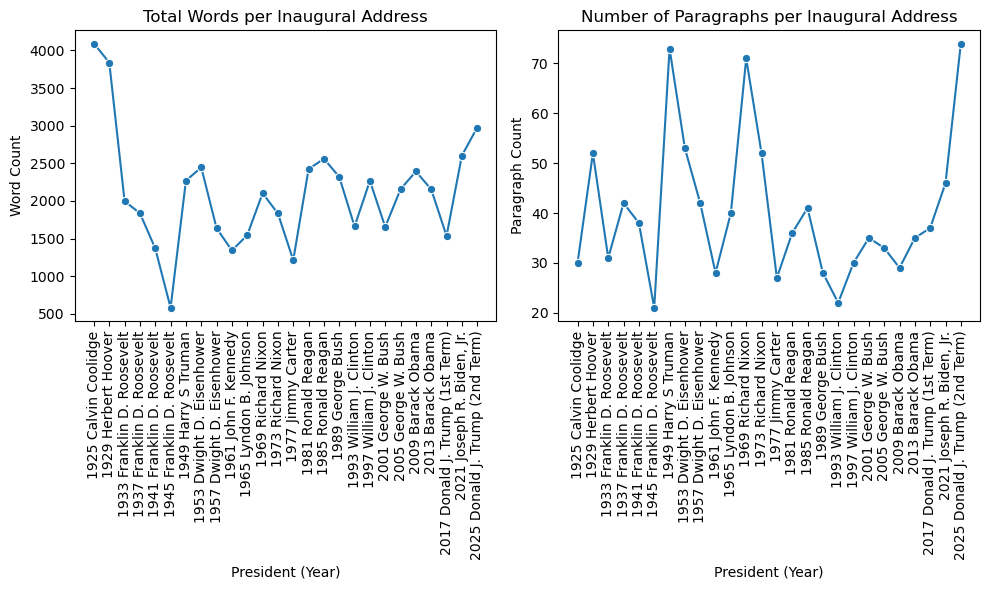

In [270]:
# Set figure and axis layout
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True)

# Plot total words per speech
sns.lineplot(ax=axes[0], data=df_groupby, x='president_year', y='no_word', marker='o')
axes[0].set_title('Total Words per Inaugural Address')
axes[0].set_xlabel('President (Year)')
axes[0].set_ylabel('Word Count')
axes[0].tick_params(axis='x', rotation=90)

# Plot number of paragraphs per speech
sns.lineplot(ax=axes[1], data=df_groupby, x='president_year', y='no_paragraph', marker='o')
axes[1].set_title('Number of Paragraphs per Inaugural Address')
axes[1].set_xlabel('President (Year)')
axes[1].set_ylabel('Paragraph Count')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


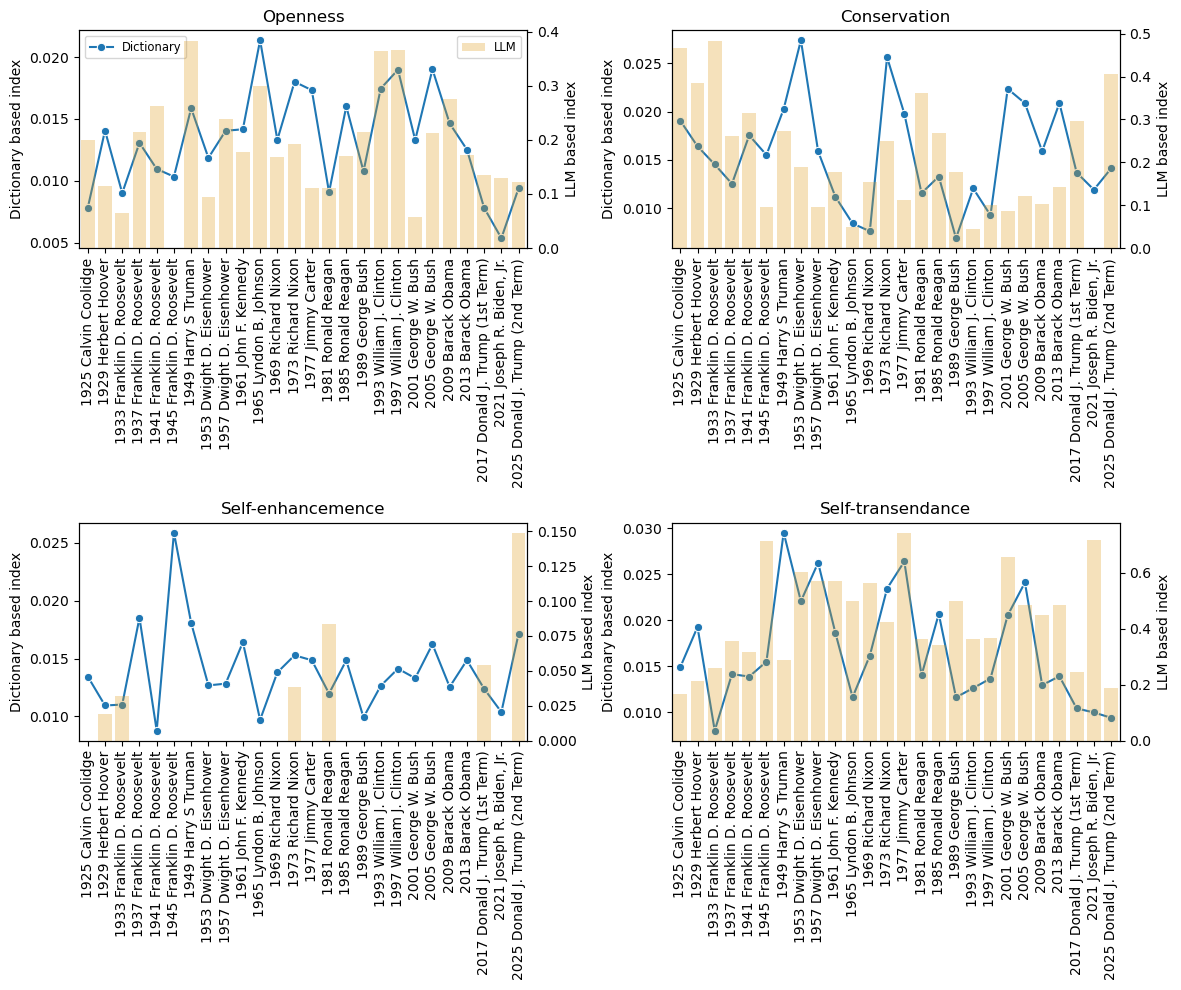

In [271]:
#plot values by all parties
# Set figure and axis layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
axes = axes.flatten()
# Plot total words per speech

sns.lineplot(ax=axes[0], data=df_groupby, x='president_year', y='openess_perc', marker='o', label='Dictionary')
axes[0].set_title('Openness')
axes[0].set_xlabel('')
axes[0].set_ylabel('Dictionary based index')
axes[0].tick_params(axis='x', rotation=90)
ax02 = axes[0].twinx()
sns.barplot(ax=ax02, data=df_groupby, x='president_year', y='llm_openess', alpha=0.3, color='orange', label='LLM')
axes[0].legend(loc='upper left', fontsize='small')
ax02.set_ylabel('LLM based index')
ax02.legend(loc='upper right', fontsize='small')


sns.lineplot(ax=axes[1], data=df_groupby, x='president_year', y='conservation_perc', marker='o')
axes[1].set_title('Conservation')
axes[1].set_xlabel('')
axes[1].set_ylabel('Dictionary based index')
axes[1].tick_params(axis='x', rotation=90)
ax12 = axes[1].twinx()
sns.barplot(ax=ax12, data=df_groupby, x='president_year', y='llm_conservation', alpha=0.3, color='orange')
ax12.set_ylabel('LLM based index')


# Plot number of paragraphs per speech
sns.lineplot(ax=axes[2], data=df_groupby, x='president_year', y='self_en_perc', marker='o')
axes[2].set_title('Self-enhancemence')
axes[2].set_xlabel('')
axes[2].set_ylabel('Dictionary based index')
axes[2].tick_params(axis='x', rotation=90)
ax22 = axes[2].twinx()
sns.barplot(ax=ax22, data=df_groupby, x='president_year', y='llm_selfenhancement', alpha=0.3, color='orange')
ax22.set_ylabel('LLM based index')


sns.lineplot(ax=axes[3], data=df_groupby, x='president_year', y='self_trancd_perc', marker='o')
axes[3].set_title('Self-transendance')
axes[3].set_xlabel('')
axes[3].set_ylabel('Dictionary based index')
axes[3].tick_params(axis='x', rotation=90)
ax32 = axes[3].twinx()
sns.barplot(ax=ax32, data=df_groupby, x='president_year', y='llm_selftranscendence', alpha=0.3, color='orange')
ax32.set_ylabel('LLM based index')


# Adjust layout
plt.tight_layout()
plt.show()

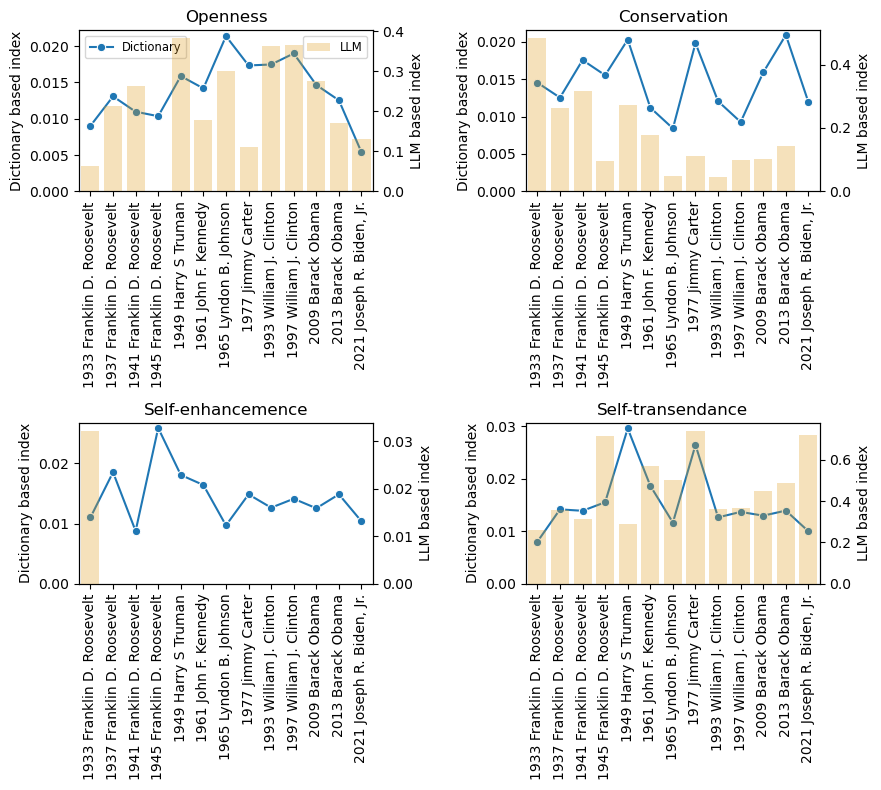

In [272]:
#plot values for democrats 
df_party = df_groupby[ df_groupby['party'] == 'Democrat' ]

# Set figure and axis layout
fig, axes = plt.subplots(2, 2, figsize=(9, 8), sharex=False)
axes = axes.flatten()
# Plot total words per speech

sns.lineplot(ax=axes[0], data=df_party, x='president_year', y='openess_perc', marker='o', label='Dictionary')
axes[0].set_title('Openness')
axes[0].set_xlabel('')
axes[0].set_ylabel('Dictionary based index')
axes[0].tick_params(axis='x', rotation=90)
ax02 = axes[0].twinx()
sns.barplot(ax=ax02, data=df_party, x='president_year', y='llm_openess', alpha=0.3, color='orange', label='LLM')
axes[0].legend(loc='upper left', fontsize='small')
ax02.set_ylabel('LLM based index')
ax02.legend(loc='upper right', fontsize='small')
axes[0].set_ylim(bottom=0) 

sns.lineplot(ax=axes[1], data=df_party, x='president_year', y='conservation_perc', marker='o')
axes[1].set_title('Conservation')
axes[1].set_xlabel('')
axes[1].set_ylabel('Dictionary based index')
axes[1].tick_params(axis='x', rotation=90)
ax12 = axes[1].twinx()
sns.barplot(ax=ax12, data=df_party, x='president_year', y='llm_conservation', alpha=0.3, color='orange')
ax12.set_ylabel('LLM based index')
axes[1].set_ylim(bottom=0) 

# Plot number of paragraphs per speech
sns.lineplot(ax=axes[2], data=df_party, x='president_year', y='self_en_perc', marker='o')
axes[2].set_title('Self-enhancemence')
axes[2].set_xlabel('')
axes[2].set_ylabel('Dictionary based index')
axes[2].tick_params(axis='x', rotation=90)
ax22 = axes[2].twinx()
sns.barplot(ax=ax22, data=df_party, x='president_year', y='llm_selfenhancement', alpha=0.3, color='orange')
ax22.set_ylabel('LLM based index')
axes[2].set_ylim(bottom=0) 

sns.lineplot(ax=axes[3], data=df_party, x='president_year', y='self_trancd_perc', marker='o')
axes[3].set_title('Self-transendance')
axes[3].set_xlabel('')
axes[3].set_ylabel('Dictionary based index')
axes[3].tick_params(axis='x', rotation=90)
ax32 = axes[3].twinx()
sns.barplot(ax=ax32, data=df_party, x='president_year', y='llm_selftranscendence', alpha=0.3, color='orange')
ax32.set_ylabel('LLM based index')
axes[3].set_ylim(bottom=0) 

# Adjust layout
plt.tight_layout()
plt.show()

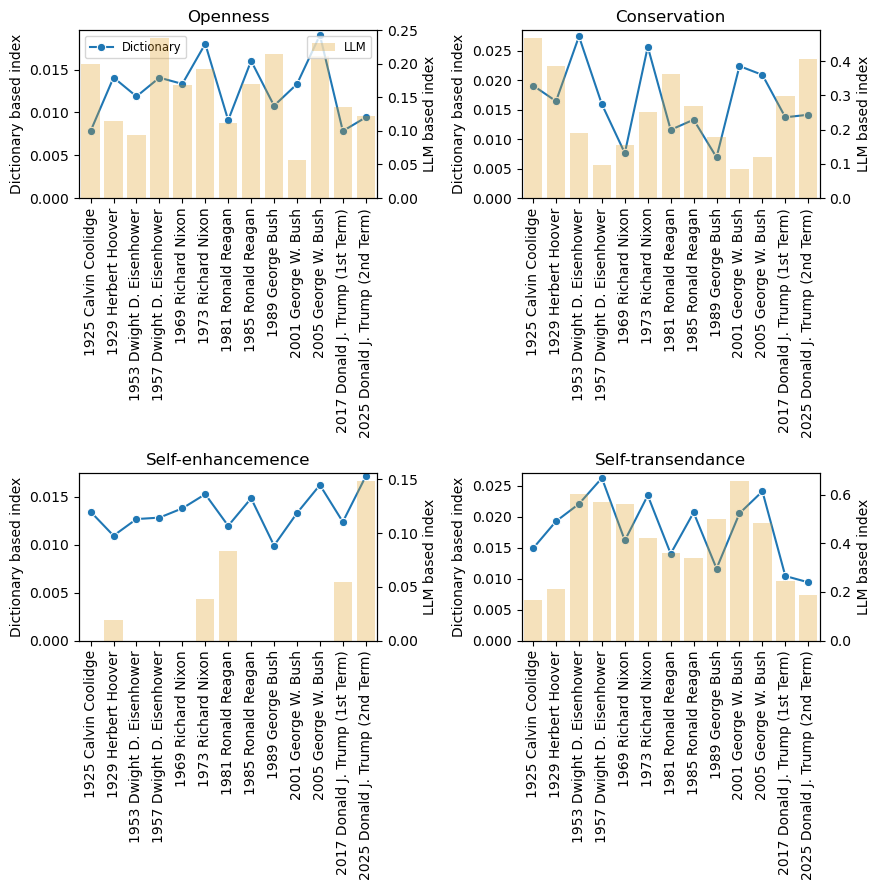

In [273]:
#plot values for republicans 

df_party = df_groupby[ df_groupby['party'] == 'Republican' ]

# Set figure and axis layout
fig, axes = plt.subplots(2, 2, figsize=(9, 9), sharex=False)
axes = axes.flatten()
# Plot total words per speech

sns.lineplot(ax=axes[0], data=df_party, x='president_year', y='openess_perc', marker='o', label='Dictionary')
axes[0].set_title('Openness')
axes[0].set_xlabel('')
axes[0].set_ylabel('Dictionary based index')
axes[0].tick_params(axis='x', rotation=90)
ax02 = axes[0].twinx()
sns.barplot(ax=ax02, data=df_party, x='president_year', y='llm_openess', alpha=0.3, color='orange', label='LLM')
axes[0].legend(loc='upper left', fontsize='small')
ax02.set_ylabel('LLM based index')
ax02.legend(loc='upper right', fontsize='small')
axes[0].set_ylim(bottom=0) 


sns.lineplot(ax=axes[1], data=df_party, x='president_year', y='conservation_perc', marker='o')
axes[1].set_title('Conservation')
axes[1].set_xlabel('')
axes[1].set_ylabel('Dictionary based index')
axes[1].tick_params(axis='x', rotation=90)
ax12 = axes[1].twinx()
sns.barplot(ax=ax12, data=df_party, x='president_year', y='llm_conservation', alpha=0.3, color='orange')
ax12.set_ylabel('LLM based index')
axes[1].set_ylim(bottom=0) 


# Plot number of paragraphs per speech
sns.lineplot(ax=axes[2], data=df_party, x='president_year', y='self_en_perc', marker='o')
axes[2].set_title('Self-enhancemence')
axes[2].set_xlabel('')
axes[2].set_ylabel('Dictionary based index')
axes[2].tick_params(axis='x', rotation=90)
ax22 = axes[2].twinx()
sns.barplot(ax=ax22, data=df_party, x='president_year', y='llm_selfenhancement', alpha=0.3, color='orange')
ax22.set_ylabel('LLM based index')
axes[2].set_ylim(bottom=0) 


sns.lineplot(ax=axes[3], data=df_party, x='president_year', y='self_trancd_perc', marker='o')
axes[3].set_title('Self-transendance')
axes[3].set_xlabel('')
axes[3].set_ylabel('Dictionary based index')
axes[3].tick_params(axis='x', rotation=90)
ax32 = axes[3].twinx()
sns.barplot(ax=ax32, data=df_party, x='president_year', y='llm_selftranscendence', alpha=0.3, color='orange')
ax32.set_ylabel('LLM based index')
axes[3].set_ylim(bottom=0) 


# Adjust layout
plt.tight_layout()
plt.show()

In [275]:
#examine self-enhancement text
df[(df['year'] == 1933) & (df['llm_value_mistral'] == 'self-enhancement') ]

,doc_id,president,year,paragraph_idx,openess_count,conservation_count,self_en_count,self_trancd_count,llm_value_mistral,text,word_count,president_year,party,openess_dict,conservation_dict,self_en_dict,self_trancd_dict
387,8,Franklin D. Roosevelt,1933,26,1,1,0,0,self-enhancement,We do not distrust the future of essential dem...,60,1933 Franklin D. Roosevelt,Democrat,{'futur': 1},{'disciplin': 1},{},{}


In [265]:
df.loc[387,'text' ]

'We do not distrust the future of essential democracy. The people of the United States have not failed. In their need they have registered a mandate that they want direct, vigorous action. They have asked for discipline and direction under leadership. They have made me the present instrument of their wishes. In the spirit of the gift I take it.'

In [274]:
#examine openness text
df[(df['year'] == 2001)].sort_values('openess_count', ascending=False)

,doc_id,president,year,paragraph_idx,openess_count,conservation_count,self_en_count,self_trancd_count,llm_value_mistral,text,word_count,president_year,party,openess_dict,conservation_dict,self_en_dict,self_trancd_dict
765,52,George W. Bush,2001,30,3,0,1,0,self-transcendence,Much time has passed since Jefferson arrived f...,36,2001 George W. Bush,Republican,"{'chang': 1, 'dream': 1, 'courag': 1}",{},{'courag': 1},{}
750,52,George W. Bush,2001,15,3,0,1,0,self-transcendence,America at its best is also courageous. Our na...,65,2001 George W. Bush,Republican,"{'futur': 1, 'courag': 2, 'inspir': 1}",{},{'courag': 2},{}
743,52,George W. Bush,2001,8,2,2,0,2,openness,"Through much of the last century, America's fa...",79,2001 George W. Bush,Republican,"{'freedom': 1, 'hope': 1}",{'faith': 2},{},"{'freedom': 1, 'hope': 1}"
761,52,George W. Bush,2001,26,2,1,1,3,self-transcendence,I will live and lead by these principles: to a...,57,2001 George W. Bush,Republican,"{'advanc': 1, 'lead': 1}",{'respons': 1},{'lead': 1},"{'justic': 1, 'care': 1, 'serv': 1}"
752,52,George W. Bush,2001,17,2,2,2,1,conservation,"We will build our defenses beyond challenge, l...",57,2001 George W. Bush,Republican,"{'liberti': 1, 'new': 2}","{'countri': 1, 'defens': 1}","{'power': 1, 'build': 1}",{'liberti': 1}
738,52,George W. Bush,2001,3,1,3,1,3,neutral,"Thank you, all. Chief Justice Rehnquist, Presi...",44,2001 George W. Bush,Republican,{'new': 1},{'tradit': 1},{'author': 1},"{'justic': 1, 'peac': 1, 'affirm': 1}"
748,52,George W. Bush,2001,13,1,1,1,1,self-transcendence,Some seem to believe that our politics can aff...,84,2001 George W. Bush,Republican,{'lead': 1},{'countri': 1},{'lead': 1},{'peac': 1}
766,52,George W. Bush,2001,31,1,2,2,3,self-transcendence,"We are not this story's author, who fills time...",80,2001 George W. Bush,Republican,{'renew': 1},"{'duti': 1, 'countri': 1}",{'achiev': 1},"{'digniti': 1, 'servic': 1, 'affirm': 1}"
762,52,George W. Bush,2001,27,1,2,1,3,self-transcendence,What you do is as important as anything Govern...,59,2001 George W. Bush,Republican,{'reform': 1},"{'respons': 1, 'defend': 1}",{'build': 1},"{'servic': 1, 'communiti': 1, 'serv': 1}"
751,52,George W. Bush,2001,16,1,1,2,1,conservation,Together we will reclaim America's schools bef...,53,2001 George W. Bush,Republican,{'reform': 1},{'secur': 1},"{'power': 1, 'secur': 1}",{'togeth': 1}


In [261]:
df.loc[765,'text' ]

"Much time has passed since Jefferson arrived for his inauguration. The years and changes accumulate, but the themes of this day, he would know: our Nation's grand story of courage and its simple dream of dignity."

In [262]:
df.loc[750,'text' ]

'America at its best is also courageous. Our national courage has been clear in times of depression and war, when defeating common dangers defined our common good. Now we must choose if the example of our fathers and mothers will inspire us or condemn us. We must show courage in a time of blessing by confronting problems instead of passing them on to future generations.'

In [278]:
#examine self transcendence values
df[(df['year'] == 2021)].sort_values('self_trancd_count', ascending=False)

,doc_id,president,year,paragraph_idx,openess_count,conservation_count,self_en_count,self_trancd_count,llm_value_mistral,text,word_count,president_year,party,openess_dict,conservation_dict,self_en_dict,self_trancd_dict
785,53,"Joseph R. Biden, Jr.",2021,12,1,3,3,3,self-transcendence,"With unity we can do great things, important t...",72,"2021 Joseph R. Biden, Jr.",Democrat,{'lead': 1},"{'secur': 1, 'uniti': 1, 'safe': 1}","{'great': 1, 'secur': 1, 'lead': 1}","{'care': 1, 'uniti': 1, 'right': 1}"
786,53,"Joseph R. Biden, Jr.",2021,13,0,1,1,3,self-transcendence,I know speaking of unity can sound to some lik...,77,"2021 Joseph R. Biden, Jr.",Democrat,{},{'uniti': 1},{'victori': 1},"{'equal': 1, 'uniti': 1}"
787,53,"Joseph R. Biden, Jr.",2021,14,0,0,1,2,self-transcendence,"Through the Civil War, the Great Depression, W...",56,"2021 Joseph R. Biden, Jr.",Democrat,{},{},{'great': 1},"{'togeth': 1, 'civil': 1}"
800,53,"Joseph R. Biden, Jr.",2021,27,2,0,0,2,self-transcendence,"Look, I understand that many of my fellow Amer...",164,"2021 Joseph R. Biden, Jr.",Democrat,"{'futur': 1, 'open': 1}",{},{},"{'toler': 1, 'open': 1}"
797,53,"Joseph R. Biden, Jr.",2021,24,1,3,1,2,self-transcendence,"To all those who supported our campaign, I am ...",119,"2021 Joseph R. Biden, Jr.",Democrat,{'lead': 1},"{'faith': 1, 'humbl': 1}",{'lead': 1},"{'right': 1, 'support': 3}"
778,53,"Joseph R. Biden, Jr.",2021,5,0,0,2,2,self-transcendence,"So now, on this hallowed ground where just a f...",133,"2021 Joseph R. Biden, Jr.",Democrat,{},{},"{'power': 1, 'strength': 1}","{'peac': 1, 'togeth': 1}"
781,53,"Joseph R. Biden, Jr.",2021,8,1,1,1,1,self-transcendence,Few people in our Nation's history have been m...,125,"2021 Joseph R. Biden, Jr.",Democrat,{'dream': 1},{'countri': 1},{'rise': 1},{'justic': 2}
803,53,"Joseph R. Biden, Jr.",2021,30,1,0,3,1,openness,"Look, folks, all my colleagues that I served w...",104,"2021 Joseph R. Biden, Jr.",Democrat,{'lead': 1},{},"{'power': 1, 'strong': 1, 'lead': 1}",{'serv': 1}
814,53,"Joseph R. Biden, Jr.",2021,41,2,1,1,1,self-transcendence,"May this be the story that guides us, the stor...",76,"2021 Joseph R. Biden, Jr.",Democrat,"{'liberti': 1, 'inspir': 1}",{'secur': 1},{'secur': 1},{'liberti': 1}
794,53,"Joseph R. Biden, Jr.",2021,21,0,0,0,1,openness,"Here we stand, where 108 years ago, at another...",51,"2021 Joseph R. Biden, Jr.",Democrat,{},{},{},{'right': 1}


In [279]:
df[(df['year'] == 2021) & (df['llm_value_mistral'] == 'self-transcendence')  & (df['self_trancd_count'] == 0)   ]

,doc_id,president,year,paragraph_idx,openess_count,conservation_count,self_en_count,self_trancd_count,llm_value_mistral,text,word_count,president_year,party,openess_dict,conservation_dict,self_en_dict,self_trancd_dict
779,53,"Joseph R. Biden, Jr.",2021,6,0,2,0,0,self-transcendence,I have just taken the sacred oath each of thes...,51,"2021 Joseph R. Biden, Jr.",Democrat,{},"{'patriot': 1, 'sacr': 1}",{},{}
782,53,"Joseph R. Biden, Jr.",2021,9,1,2,1,0,self-transcendence,To overcome these challenges—to restore the so...,31,"2021 Joseph R. Biden, Jr.",Democrat,{'futur': 1},"{'secur': 1, 'restor': 1}",{'secur': 1},{}
783,53,"Joseph R. Biden, Jr.",2021,10,1,0,0,0,self-transcendence,"In another January on New Year's Day in 1863, ...",54,"2021 Joseph R. Biden, Jr.",Democrat,{'new': 1},{},{},{}
784,53,"Joseph R. Biden, Jr.",2021,11,0,0,0,0,self-transcendence,"Today, on this January day, my whole soul is i...",49,"2021 Joseph R. Biden, Jr.",Democrat,{},{},{},{}
793,53,"Joseph R. Biden, Jr.",2021,20,0,0,1,0,self-transcendence,Here we stand looking out on the great Mall wh...,16,"2021 Joseph R. Biden, Jr.",Democrat,{},{},{'great': 1},{}
795,53,"Joseph R. Biden, Jr.",2021,22,0,0,0,0,self-transcendence,Here we stand across the Potomac from Arlingto...,23,"2021 Joseph R. Biden, Jr.",Democrat,{},{},{},{}
796,53,"Joseph R. Biden, Jr.",2021,23,0,1,1,0,self-transcendence,"And here we stand, just days after a riotous m...",51,"2021 Joseph R. Biden, Jr.",Democrat,{},{'sacr': 1},{'drive': 1},{}
798,53,"Joseph R. Biden, Jr.",2021,25,0,0,0,0,self-transcendence,"Many centuries ago, Saint Augustine, a saint o...",60,"2021 Joseph R. Biden, Jr.",Democrat,{},{},{},{}
799,53,"Joseph R. Biden, Jr.",2021,26,0,4,1,0,self-transcendence,Recent weeks and months have taught us a painf...,60,"2021 Joseph R. Biden, Jr.",Democrat,{},"{'duti': 1, 'protect': 1, 'defend': 1, 'honor'...",{'power': 1},{}
801,53,"Joseph R. Biden, Jr.",2021,28,0,1,0,0,self-transcendence,Because here is the thing about life: There is...,72,"2021 Joseph R. Biden, Jr.",Democrat,{},{'countri': 1},{},{}


In [282]:
df.loc[783,'text' ]

'In another January on New Year\'s Day in 1863, Abraham Lincoln signed the Emancipation Proclamation. When he put pen to paper, the President said, and I quote, "If my name ever goes down into history it will be for this act, and my whole soul is in it." My whole soul is in it.'

In [285]:
df.loc[795,'text' ]

'Here we stand across the Potomac from Arlington Cemetery, where heroes who gave the last full measure of devotion rest in eternal peace.'

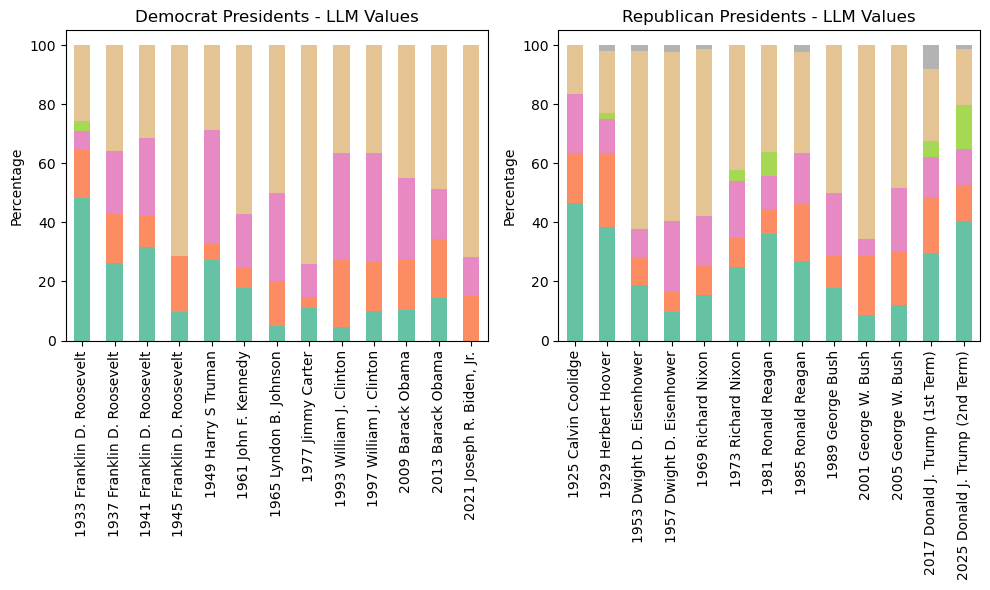

In [302]:
# plot llm index as percentage for easy looking trend
# Step 1: Group and count
grouped = df.groupby(['party', 'president_year', 'llm_value_mistral']).size().reset_index(name='count')

# Step 2: Pivot for plotting
pivoted = grouped.pivot_table(index=['party', 'president_year'], 
                               columns='llm_value_mistral', 
                               values='count', 
                               fill_value=0)

# Step 3: Convert counts to percentages (row-wise)
percentages = pivoted.div(pivoted.sum(axis=1), axis=0) * 100

# Step 4: Split by party
democrat_data = percentages.loc['Democrat']
republican_data = percentages.loc['Republican']

# Step 5: Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharex=False)

# Democrat subplot
democrat_data.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set2',legend=False)
axes[0].set_title('Democrat Presidents - LLM Values')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('')

# Republican subplot
republican_data.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set2',legend=False)
axes[1].set_title('Republican Presidents - LLM Values')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('')

# Final touches
plt.xlabel('')
plt.tight_layout()
plt.show()

